## Introduction

The goal of this assigment is to build a deep learning based generative models that can generate new images samples using Keras framework. Unsupervised artificial neural networks such as Auto Encoders, Variational Auto Encoders and Generative Adversarial Networks(GAN's) can be used to generate high realistic images. An important step in the assignment is to design the networks with same image generation architecture in order to study how the networks generate different quality of images while using common set of parameters. The assignment is divided into 5 parts as follows:

1) Choosing the dataset that can be used for image generation

2) Implement Auto Encoder

3) Implement Variational Auto Encoder

4) Implement GAN networks

5) Generate new samples using the trained model.

## Part 1 :  Choosing the dataset that can be used for image generation

The first step is to choose a dataset that can be used for implementing image generation. There are wide variety of applications for which we can use the deep generative models for, some of the applications are:

1) Generating examples of image datasets

2) Generating photographs of human faces

3) Image-to-Image translation and so on

After researching through few of the datasets like Anime charectar generation data set, Face aging datasets(UKface dataset) and Fashion MNSIT dataset, we decided to go ahead with the **Fashion MNSIT** data set.


An application area which is currently having prospects for quick real-world adoption is "Generating examples of image datasets". Fashion (Clothes, shoes, bag, etc..)industry already has lot of pre-existing designs, but there is always a necessity of creating new desings frequently to keep up with the growing demands. Creating new desings for clothes is a tedious task,the neural networks models can use this data and automate the tedious work by generating new designs and produce good quality images,thus reducing the human effort.

For the above reasons, we decided to go with the "Fashion MNSIT" dataset. 


Refrences/ Websites that we searched for data on:

1) 18 Impressive Applications of Generative Adversarial Networks (GANs) (https://machinelearningmastery.com/impressive-applications-of-generative-adversarial-networks/)

2) Kaggle Data sets (https://www.kaggle.com/datasets?search=gl&tags=13207-Computer+Vision)

3) Paperswithcode (https://paperswithcode.com/dataset/lsun)



**Fashion MNSIT** dataset is present in keras library, we imported this dataset directly into the jupyter notebook using load_data() function of tensorflow. 

This data set contains 60,000 images of size (28 * 28) of 10 different categories. The test dataset contains 10,000 images (We will not be using it ).

The different classes which are present in the data are as follows:

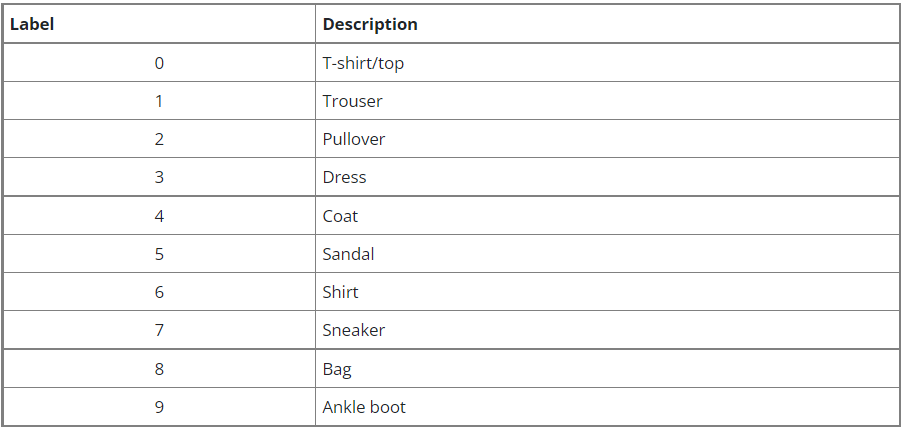


References:

1) Keras Datasets (https://keras.io/api/datasets/fashion_mnist/)

### Loading and preprocessing the data set

In [2]:
# Importing requiered libraies

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow.compat.v1.keras.backend as K
from tensorflow.keras.layers import (Input,Dense, 
                                     BatchNormalization,
                                     LeakyReLU,
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)

from tensorflow.keras.models import Model
from keras.datasets import fashion_mnist
import numpy as np
import tensorflow.keras as keras
from keras.optimizers import adam_v2
import pandas as pd
import time
import sys
from tqdm.autonotebook import tqdm
from IPython import display
import os


import matplotlib.pyplot as plt
%matplotlib inline

<ipython-input-2-5a089c2125da>:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# Setting all the image size to width of 20 and height of 10 for this notebook
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
# Function to import datasets
def import_dataset():
    # Train-test split
    (img_train, img_train_lbl), (img_test, img_test_lbl) = tf.keras.datasets.fashion_mnist.load_data()
    
    return img_train, img_train_lbl,img_test,img_test_lbl


In [4]:
# Calling import function
img_train, img_train_lbl,img_test,img_test_lbl = import_dataset()

In [5]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (img_train.shape, img_train_lbl.shape))
print('Test: X=%s, y=%s' % (img_test.shape, img_test_lbl.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


### Plotting Train images 

#### Colored images

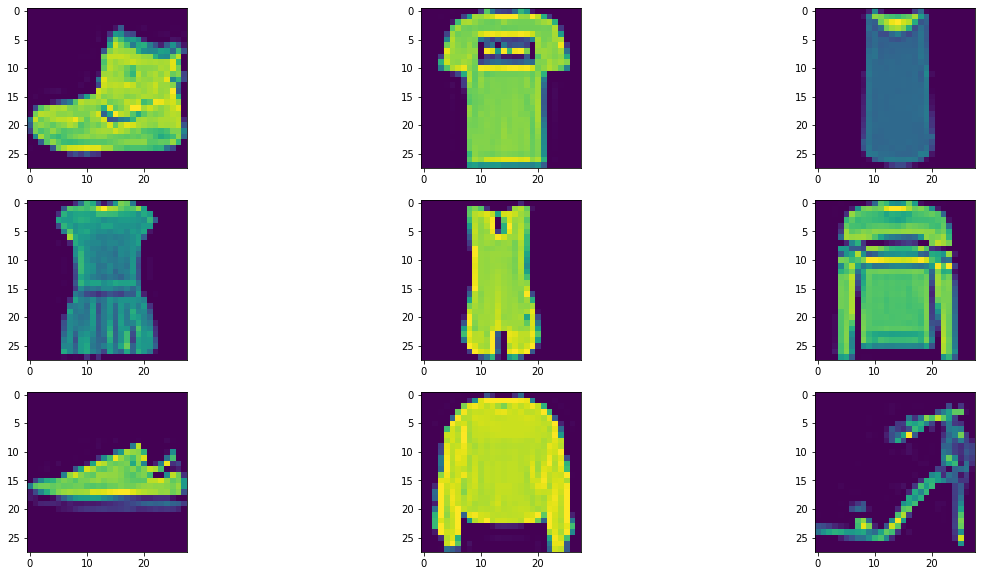

In [6]:
# plot first nine images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(img_train[i])
# show the figure
plt.show()

#### Grey-scale images

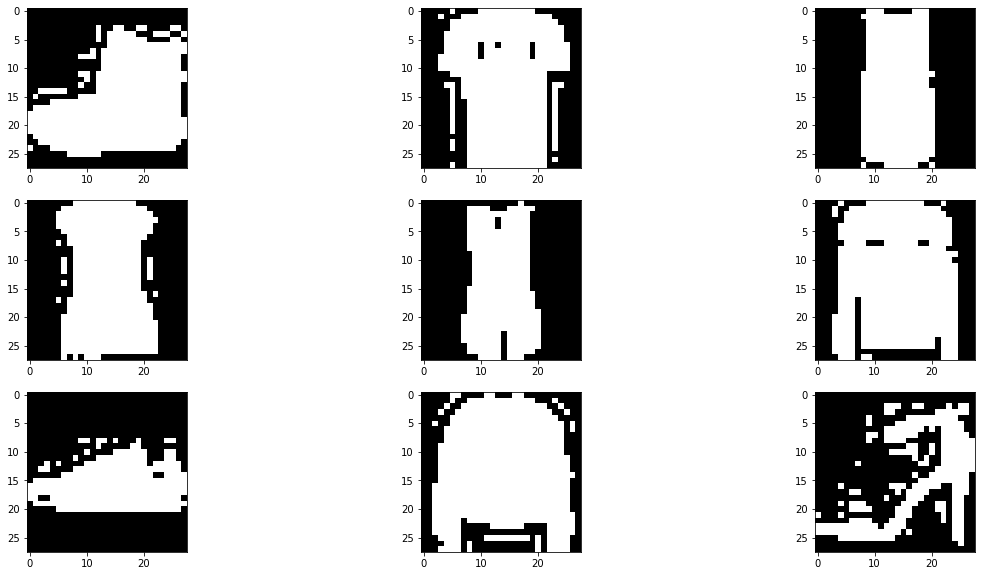

In [7]:
# colored image to grey scale
# plot first six images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(img_train[i], cmap = plt.get_cmap('gray'), vmin=0, vmax=1)     
# show the figure
plt.show()

### Data-preprocessing 

In [8]:
def data_preprocessing(img_data):
    
    img_data = img_data.astype(np.float32) / 255.0
    img_data = np.expand_dims(img_data, axis=3)
    img_data = img_data.reshape((len(img_data), np.prod(img_data.shape[1:])))
    
    return img_data
    

In [9]:
img_train = data_preprocessing(img_train)
img_test = data_preprocessing(img_test)
print(img_train.shape)
print(img_test.shape)

(60000, 784)
(10000, 784)


## Part 2: Auto Encoder Implementation

Autoencoders (also known as Bottle-neck Neural networks) are an unsupervised deep generative model that learns how to compress and encode data effectively before reconstructing it back to a representation that is as similar to the original input.

Auto encoders has four main components :

1) **Encoder** : Enoders perform dimensionality reduction i.e, the dimension of the input data is reduced by reducing the number of features that describe the data and compresses the image into an encoded representation.

2) **BottleNeck** : This layer holds the encoded representations sent by the encoder.

3) **Decoder**: It learns to recontruct the data from the encoded data which is present at bottleneck layer.

4) **Reconstruction loss**: It is a measure used for assessing the performance of the decoder, and how close is the generated image to the actual image.

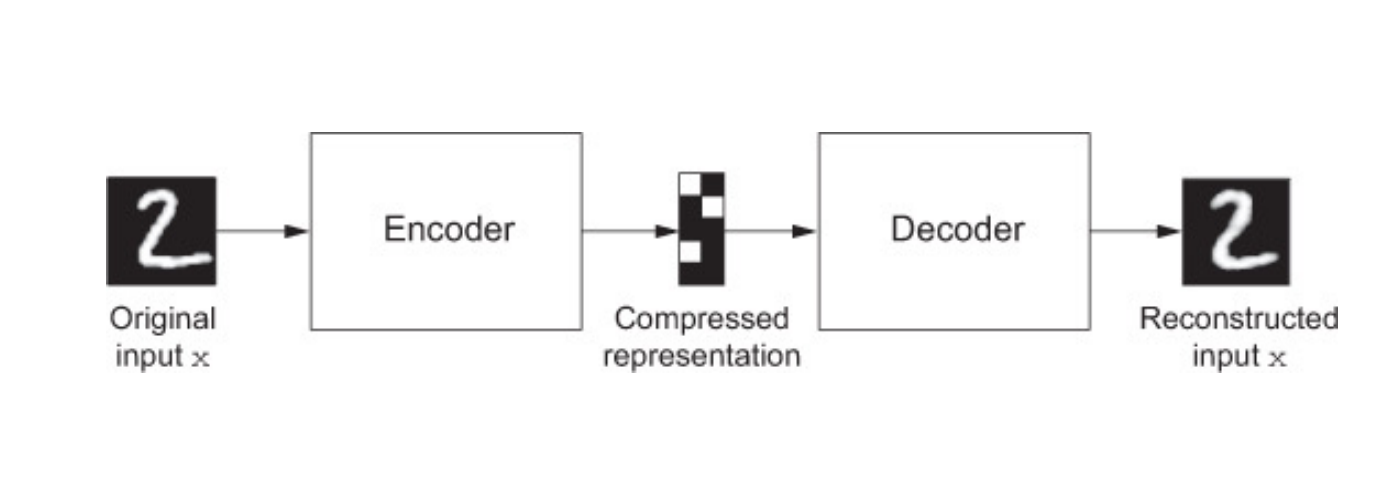


The archtiecture of auto encoders is represented in the above image.


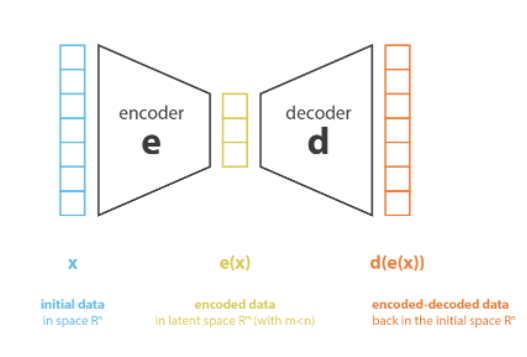

The dimesionality reduction preocess is shown in the above image.


**References:**

1) Deep Learning Module Notes - week 8- Dr James McDermott

2) Auto Enoders: what is it? (https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726)


### Implementing Auto-Encoders

##### Encoding Layer  construction

In [10]:
# Encoding dimensions
encoding_dim = 32

# input image
input_img = keras.Input(shape=(784,))

# encoded representation of the input
z_rep = layers.Dense(encoding_dim, activation='relu')(input_img)

# reconstruction of the input with the loss
decoded_img = layers.Dense(784, activation='sigmoid')(z_rep)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded_img)

In [11]:
# Calling the encoder
encoder = keras.Model(input_img, z_rep)

##### Decoding layer construction

In [12]:
# reduced dimensional input
encoded_input = keras.Input(shape=(encoding_dim,))

# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

##### Compiling and training Auto Encoder

In [13]:
autoencoder.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=["accuracy"],
                    run_eagerly=True
                   )

In [14]:
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
history = autoencoder.fit(img_train, img_train,
                epochs=150,
                batch_size=256,
                shuffle=True,
                validation_data=(img_test, img_test))

Epoch 1/150
235/235 [==============================] - 3s 14ms/step - loss: 0.4162 - accuracy: 0.0078 - val_loss: 0.3399 - val_accuracy: 0.0111
Epoch 2/150
235/235 [==============================] - 3s 13ms/step - loss: 0.3259 - accuracy: 0.0124 - val_loss: 0.3186 - val_accuracy: 0.0151
Epoch 3/150
235/235 [==============================] - 3s 13ms/step - loss: 0.3106 - accuracy: 0.0140 - val_loss: 0.3076 - val_accuracy: 0.0180
Epoch 4/150
235/235 [==============================] - 3s 13ms/step - loss: 0.3013 - accuracy: 0.0168 - val_loss: 0.2997 - val_accuracy: 0.0195
Epoch 5/150
235/235 [==============================] - 3s 13ms/step - loss: 0.2947 - accuracy: 0.0185 - val_loss: 0.2946 - val_accuracy: 0.0201
Epoch 6/150
235/235 [==============================] - 3s 13ms/step - loss: 0.2910 - accuracy: 0.0195 - val_loss: 0.2918 - val_accuracy: 0.0242
Epoch 7/150
235/235 [==============================] - 3s 13ms/step - loss: 0.2887 - accuracy: 0.0205 - val_loss: 0.2900 - val_accuracy:

235/235 [==============================] - 3s 12ms/step - loss: 0.2809 - accuracy: 0.0277 - val_loss: 0.2835 - val_accuracy: 0.0294
Epoch 114/150
235/235 [==============================] - 3s 12ms/step - loss: 0.2809 - accuracy: 0.0278 - val_loss: 0.2835 - val_accuracy: 0.0299
Epoch 115/150
235/235 [==============================] - 3s 12ms/step - loss: 0.2809 - accuracy: 0.0272 - val_loss: 0.2834 - val_accuracy: 0.0291
Epoch 116/150
235/235 [==============================] - 3s 12ms/step - loss: 0.2809 - accuracy: 0.0279 - val_loss: 0.2835 - val_accuracy: 0.0309
Epoch 117/150
235/235 [==============================] - 3s 12ms/step - loss: 0.2809 - accuracy: 0.0279 - val_loss: 0.2834 - val_accuracy: 0.0285
Epoch 118/150
235/235 [==============================] - 3s 12ms/step - loss: 0.2809 - accuracy: 0.0274 - val_loss: 0.2834 - val_accuracy: 0.0302
Epoch 119/150
235/235 [==============================] - 3s 12ms/step - loss: 0.2809 - accuracy: 0.0274 - val_loss: 0.2834 - val_accuracy:

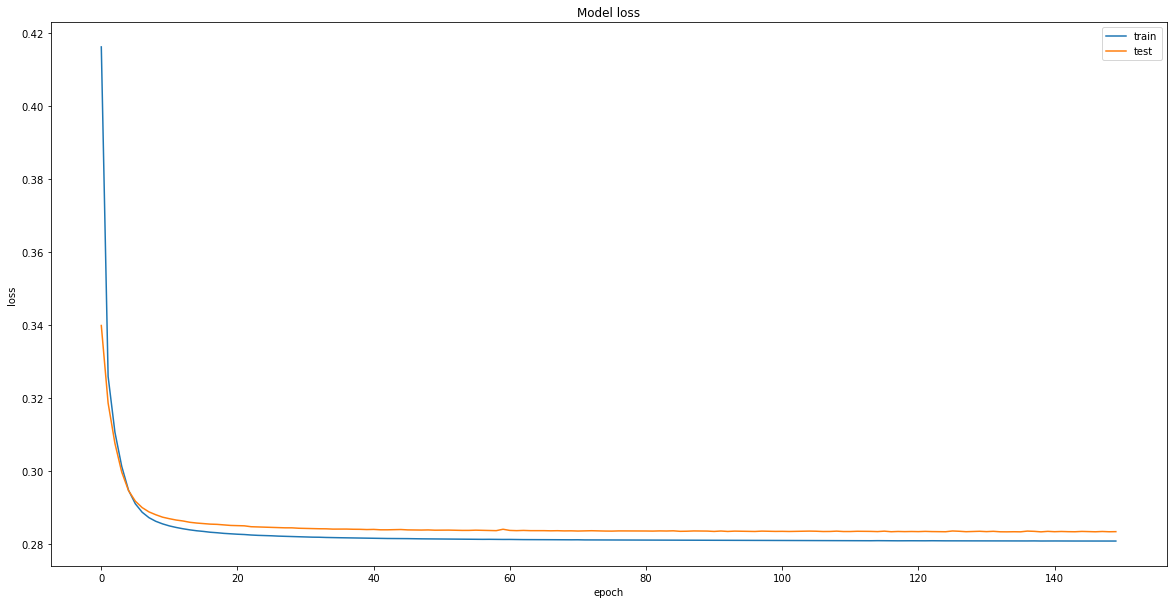

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Trained the model for 150 epochs, did not see significant changes in loss after 8 epochs.

In [17]:
# Generating images
encoded_imgs = encoder.predict(img_test)
decoded_imgs = decoder.predict(encoded_imgs)

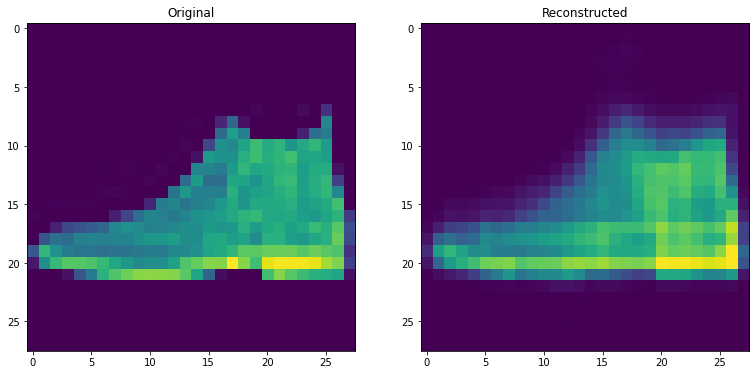

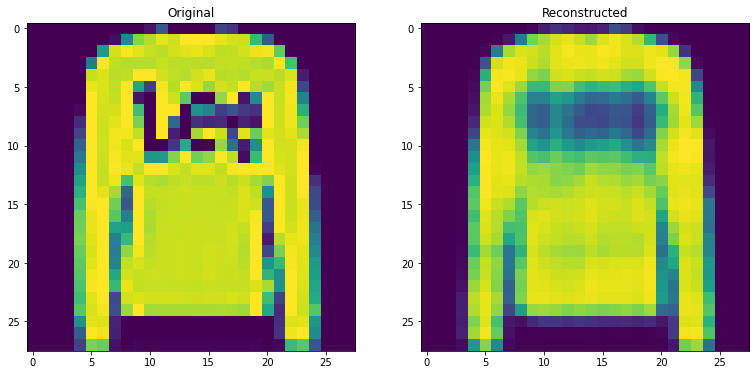

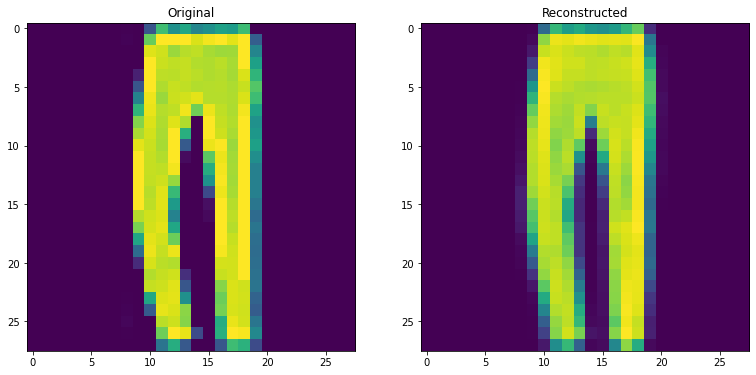

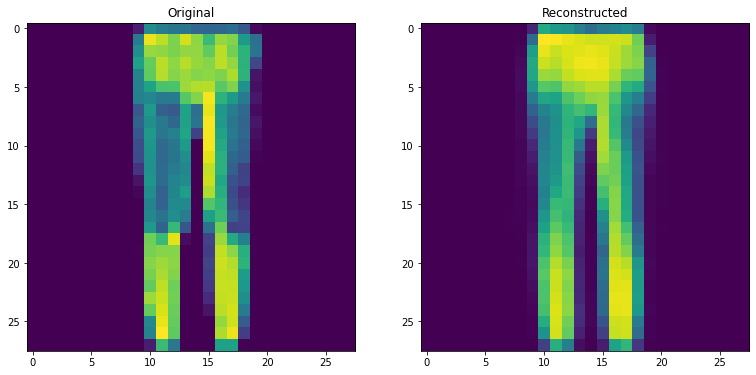

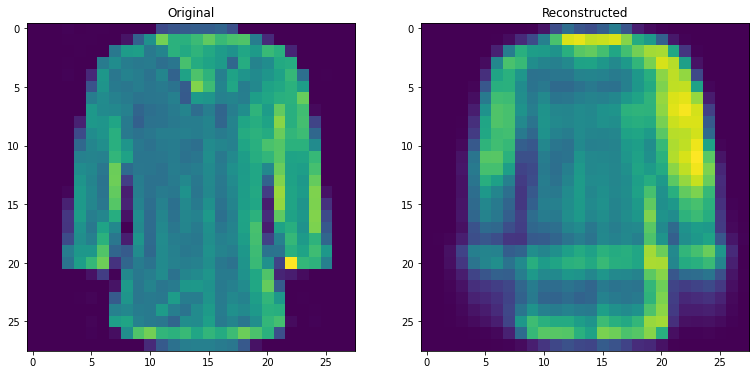

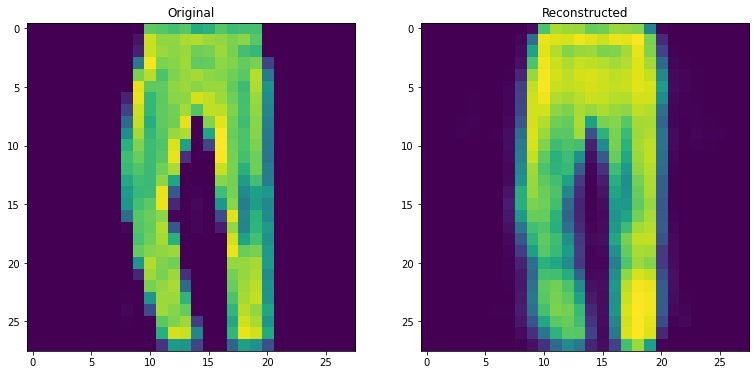

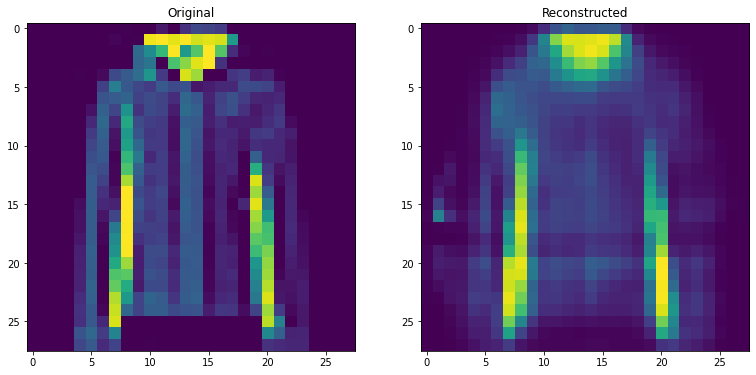

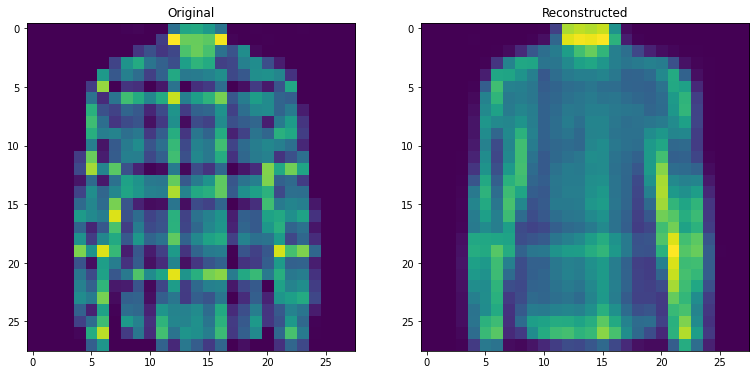

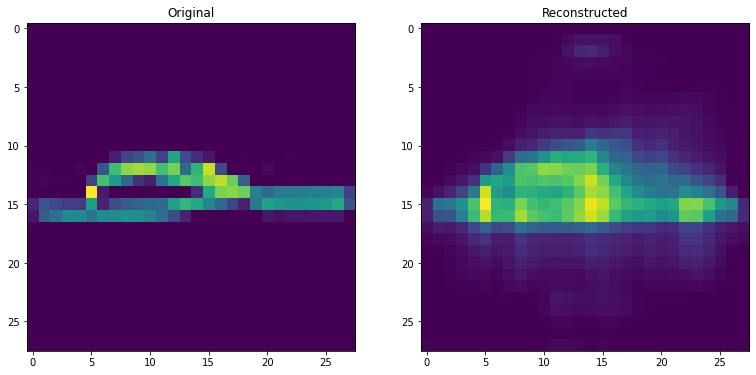

In [18]:
# Visualize the reconstructed images
for i in range(9):
    
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img_test[i].reshape(28, 28))
    
    plt.subplot(1,3,2)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    
    # show the figure
    plt.show()

From the above reconstructed images, we can see that the constructed image quality is not that great. But we encoded the features into a 32 dimensional vector, we have reduced the data and there is loss of information, keeping these things in mind the proposed decoder model is performing well in recontructing the data, we also tried increasing the feature dimension to 256 and we could see good reconstruction image generation from the decoder.The latent space (BottleNeck) in auto encoders is not regularised and may lead to overfitting of the trining data, in order to have a regularised latent space and improve the generation capblity of the decoder, we need a Variational Auto Encoder.

**References:**

1) Deep Learning Module Notes and code - week 8- Dr James McDermott

2) Auto-Encoder: What Is It? ,(https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726)

3) Auto encoders for image reconstruction , (https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/)

## Part 3: Variational Auto Encoder Implementation

The latent space is irregualr in auto encoder and thus sometimes leads to over fitting, and we can't truly call something generative if it only samples a point from the latent space and sends it through the decoder to generate new data[2]. Variation auto encoder(VAE) solves this problem by requiring encoders to return a distribution on a latent space rather than a single point[2]. VAE's are auto encoders with a sampling and regularisation term [1] thus solving the problem of latent space irregularity. Encoder of the VAE outputs a normalised distribution to latent space which consists of Kullback-Leibler divergence, which outputs a mean and covariance matrix, next, a sampling technique is then used to sample a point from the distribution, then this point is sent to the decoder, the decoder then reconstructs the image and computes the "reconstruction loss". The reconstruction loss is then backpropogated back to the encoder during the training process. 


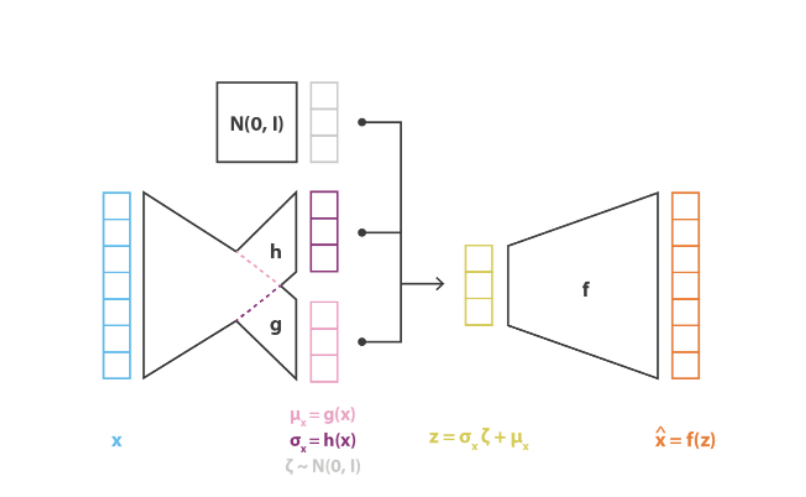



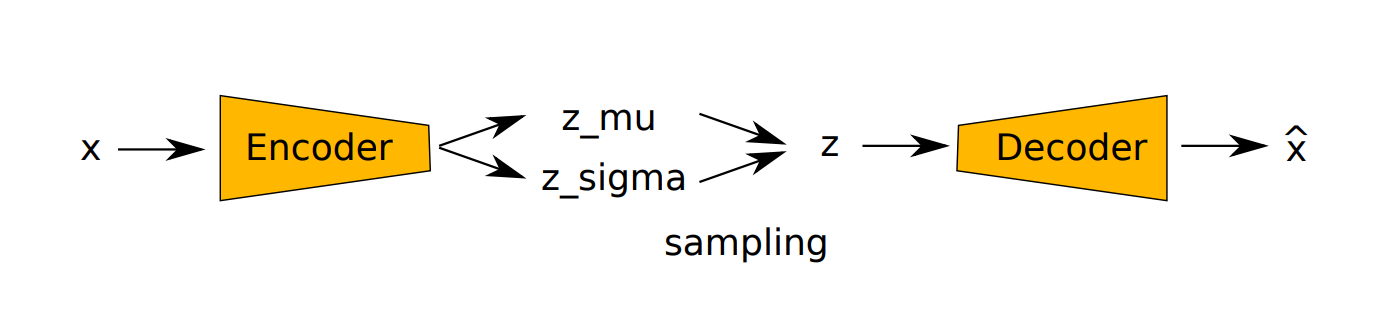


The above figures represents the architecture of VAE.


**References:**

1) Deep Learning Module Notes and code - week 8- Dr James McDermott

2) Understanding variational auto encoders (https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)



In [15]:
ds = tfp.distributions
tf.executing_eagerly()

True

In [16]:
# Initialising the parameters
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [17]:
# Reshape the datasets
train_image_VAE = img_train.reshape(img_train.shape[0], 28, 28, 1).astype("float32") 
test_image_VAE = img_test.reshape(img_test.shape[0], 28, 28, 1).astype("float32")

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_image_VAE)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_image_VAE)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

In [18]:
class VAE(tf.keras.Model):

    def __init__(self, **kwargs):
        super(VAE, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)

    def encode(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return ds.MultivariateNormalDiag(loc = mu, scale_diag = sigma)
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def reconstruct(self, x):
        mu, _ = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return self.decode(mu)
    
    def decode(self, z):
        return self.dec(z)

    def compute_loss(self, x):
        q_z = self.encode(x)
        z = q_z.sample()
        x_recon = self.decode(z)
        p_z = ds.MultivariateNormalDiag(
            loc=[0.] * z.shape[-1], scale_diag =[1.] * z.shape[-1]
        )
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.math.square(x - x_recon), axis=0))

        return recon_loss, latent_loss

    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        return tape.gradient(loss, self.trainable_variables)

    @tf.function
    def train(self, train_x):
        gradients = self.compute_gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

In [19]:
N_Z = 2

encoder = [
    tf.keras.layers.InputLayer(input_shape = DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size = 3, strides=(2,2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size = 3, strides=(2,2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=N_Z*2),
]

decoder = [
    
    tf.keras.layers.Dense(units=7*7*256, activation="relu"),
    
    tf.keras.layers.Reshape(target_shape = (7,7,256)),
    
    tf.keras.layers.Conv2DTranspose(
        filters=256, kernel_size=5, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=5, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=5, strides=(1, 1), padding="SAME", activation="tanh"
    ),
]


In [20]:
optimizer = tf.keras.optimizers.Adam(1e-3)

model = VAE(
    enc = encoder,
    dec = decoder,
    optimizer = optimizer,
)

In [21]:
example_data = next(iter(test_dataset))

def plot_reconstruction(model, example_data, nex=8, zm = 2):

    example_data_reconstruction = model.reconstruct(example_data)
    samples = model.decode(tf.random.normal(shape = (BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
    for axi, (dat, lab) in enumerate(
        zip(
            [example_data, example_data_reconstruction, samples],
            ["data", "data recon", "samples"],
        )
    ):
        for ex in range(nex):
            axs[axi, ex].matshow(
                dat.numpy()[ex].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
            )
            axs[axi, ex].axes.get_xaxis().set_ticks([])
            axs[axi, ex].axes.get_yaxis().set_ticks([])
        axs[axi, 0].set_ylabel(lab)

    plt.show()

In [22]:
losses = pd.DataFrame(columns=['Reconstruction_loss', 'Latent_loss'])

Epoch: 19 | Reconstruction_loss: 17.86814308166504 | Latent_loss: 4.1753435134887695


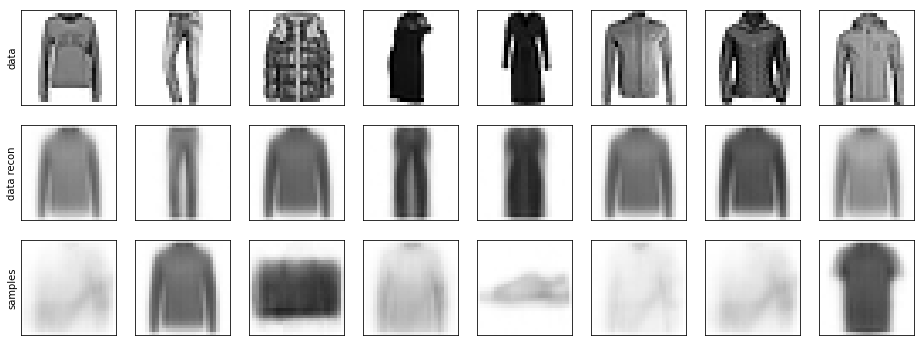

In [23]:
n_epochs = 20

for epoch in range(n_epochs):
    
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total = N_TRAIN_BATCHES
    ):
        model.train(train_x)
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
        
    losses.loc[len(losses)] = np.mean(loss, axis=0)

    display.clear_output()
    print(
        "Epoch: {} | Reconstruction_loss: {} | Latent_loss: {}".format(
            epoch, losses.Reconstruction_loss.values[-1], losses.Latent_loss.values[-1]
        )
    )
    plot_reconstruction(model, example_data)

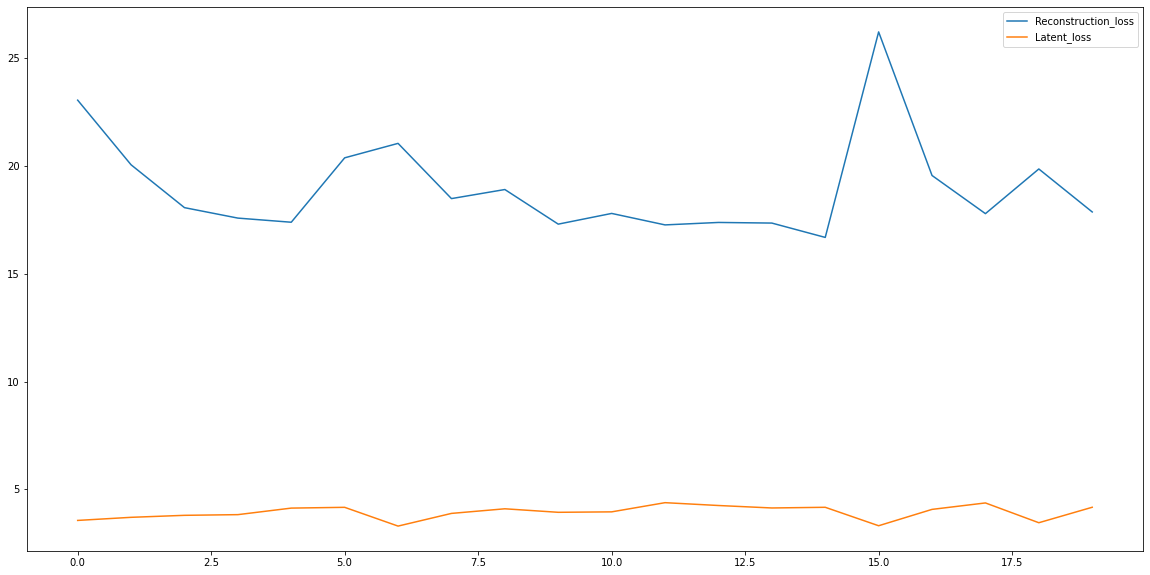

In [24]:
# Plotting Loss
losses.plot()
plt.show()

VAE's are able to generate a better images than the Auto encoders, as we know that the latent space in normal auto encoders is pretty unorganized. The latent space in auto encoders is comparitively organized due to explicit regularzation during the training process which avoids the overfitting problem of autoencoders and we take encoding input as a distribution over latent space as supposed to the single point in normal auto encoders.

## Part 4: Generative Adversarial Networks Implementation

GAN's are the regarded as one of the best ML algorithm of recent times. The GAN model for our use case is developed using a convolutional neural network. In GAN two neural network agents : A generator(maximises the classification error) and a discriminator(minimises the classification error)[1] compete with each other in a zero-sum game to generate representations which are similar to the training data set. The role of the generator is to randomly generate the data, for the descriminator an input training set is provided with the help of which the descriminator can differentiate between the real data and fake data (which is generated by a generator) and thus create classification labels on the training data set. The generator tries to learn to decieve the discriminator after few epochs by generaing data as good as the original input data, once the generator trains well on the data set it will be able to produce a good quality images. We will be implementing Deep Convolutional GAN (DCGAN).

Architecture of GAN netowrks [1]:

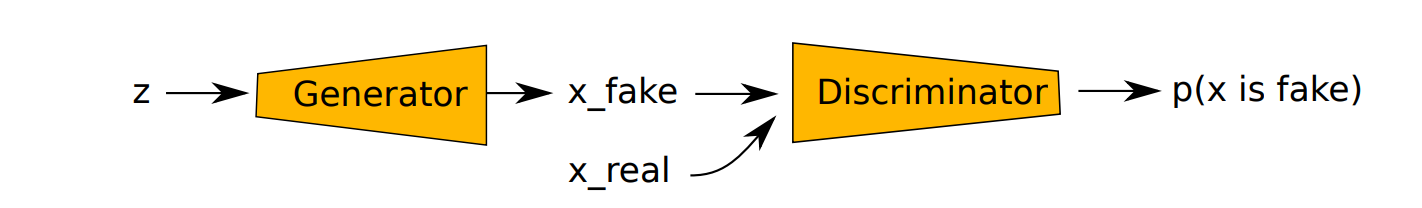

Our Model Architecture[2]:

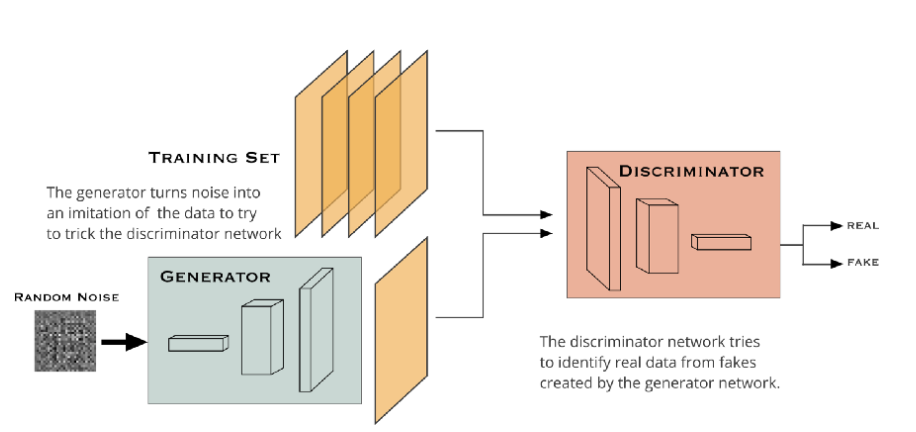


**References:**
    
1) Deep Learning Module Notes and code - week 8- Dr James McDermott

2) Image generation with GAN (https://towardsdatascience.com/image-generation-in-10-minutes-with-generative-adversarial-networks-c2afc56bfa3b)  

#### Data Preprocessing for GAN

In [4]:
(img_train, img_train_lbl), (img_test, img_test_lbl) = tf.keras.datasets.fashion_mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (img_train.shape, img_train_lbl.shape))

Train: X=(60000, 28, 28), y=(60000,)


In [5]:
def data_preprocess_GAN(img_data):
    
    # Reshape the datasets
    t_image_GAN = img_train.astype(np.float32) / 255.0
    t_image_GAN = np.expand_dims(t_image_GAN, axis=3)
    
    return t_image_GAN


In [6]:
# Data pre-processing
# Taking only train
train_img_GAN = data_preprocess_GAN(img_train)


#### Keeping the architecture of VAE's decoder and GAN's encoder same

#### Method 1 implementation of GAN

In [7]:
## Creating a generator model

def proposed_generator_agent():
    
    # Sequential model
    gan_generator = tf.keras.Sequential()
    
    # Dense layers
    gan_generator.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    
    gan_generator.add(LeakyReLU(alpha=0.2))

    gan_generator.add(BatchNormalization(momentum=0.8))
    
    
    
    gan_generator.add(Reshape((7, 7, 256)))
    
    assert gan_generator.output_shape == (None, 7, 7, 256)
    
    
    # transposed convulational layer
    # 1- dimensional array to 2-dimensional array
    gan_generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    
    assert gan_generator.output_shape == (None, 7, 7, 128)
    
    gan_generator.add(LeakyReLU(alpha=0.2))
    
    gan_generator.add(BatchNormalization(momentum=0.8))
    
    
    # transposed convulational layer
    # 1- dimensional array to 2-dimensional array
    gan_generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    
    assert gan_generator.output_shape == (None, 14, 14, 64)
    
    gan_generator.add(LeakyReLU(alpha=0.2))
    
    gan_generator.add(BatchNormalization(momentum=0.8))
    
   
    # transposed convulational layer
    # 1- dimensional array to 2-dimensional array
    gan_generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    assert gan_generator.output_shape == (None, 28, 28, 1)

    return gan_generator

In [8]:
GAN_generator = proposed_generator_agent()

Working of Discriminator:

Training Image -> Hidden layers -> Classification (class 0 or 1 (real or fake))

In [9]:
def proposed_discriminator_agent():
    
    gan_discriminator = tf.keras.Sequential()
    
    # Dense layer 1
    # tried with 3*3 kernal, did not get good results
    gan_discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    gan_discriminator.add(LeakyReLU(0.2))
    gan_discriminator.add(Dropout(0.3))

    # Dense Layer 2
    gan_discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    gan_discriminator.add(LeakyReLU(0.2))
    gan_discriminator.add(Dropout(0.3))
    
    # Flattening to apply softmax
    gan_discriminator.add(Flatten())
    gan_discriminator.add(Dense(1))

    return gan_discriminator

In [10]:
GAN_discriminator = proposed_discriminator_agent()

In [85]:
# Adam with relatively low learning rate and beta_1 (momentum decay)
GAN_discriminator.compile(loss='binary_crossentropy', 
                          optimizer=adam_v2.Adam(0.0002, 0.5),
                          metrics=['accuracy'])

In [16]:
EPOCHS = 30
num_examples_to_generate = 16
batch_size = 256
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [87]:
y_fake = np.ones((batch_size, 1))
y_real = np.zeros((batch_size, 1))

In [88]:
# Set discriminator not trainable, create GAN and optimizer for GAN
# which will train generator only, and compile
GAN_discriminator.trainable = False

z = Input(shape=(noise_dim,))

GAN = Model(z, GAN_discriminator(GAN_generator(z)))

GAN.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(0.0002, 0.5),
          metrics=['accuracy'])

GAN.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_9 (Sequential)   (None, 28, 28, 1)         2330944   
                                                                 
 sequential_10 (Sequential)  (None, 1)                 212865    
                                                                 
Total params: 2,543,809
Trainable params: 2,305,472
Non-trainable params: 238,337
_________________________________________________________________


In [89]:
def sample_images(epoch):
    # save an image to see some of our fake images
    r, c = 5, 5
    
    z = np.random.normal(0, 1, (r * c, noise_dim))
    
    x_fake = GAN_generator.predict(z)

    fig, axs = plt.subplots(r, c)
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(x_fake[i*r+j].reshape((28, 28)), cmap='gray')
            axs[i, j].axis('off')
            
    print("saving")
    plt.tight_layout()
    plt.savefig("gan_mnist.png")
    plt.close()

In [90]:
epochs = 10
steps = epochs * train_img_GAN.shape[0] // batch_size
sample_interval=100

In [ ]:
for step in range(steps):

    # choose real images, x_real, and make fake images, x_fake
    idx = np.random.randint(0, train_img_GAN.shape[0], batch_size)
    x_real = train_img_GAN[idx]
    z = np.random.normal(0, 1, (batch_size, noise_dim))
    x_fake = GAN_generator.predict(z)

    # train D
    loss_d_real = GAN_discriminator.train_on_batch(x_real, y_real)
    loss_d_fake = GAN_discriminator.train_on_batch(x_fake, y_fake)
    loss_d = 0.5 * np.add(loss_d_real, loss_d_fake)

    # train G, by training GAN
    # pass y_real, ie pretend these images are real
    loss_g = GAN.train_on_batch(z, y_real)

    # notice loss_d and loss_g are each really (loss, accuracy),
    # because we requested accuracy as a metric.
    print(f"{step:4d}/{steps} [D {loss_d[0]:.2f}, acc. (on x_real and x_fake) {100 * loss_d[1]:3.0f}] [G {loss_g[0]:.2f}, acc. (on x_fake) {100 * loss_g[1]:3.0f}]")
    if step % sample_interval == 0 or step == steps - 1:
        sample_images(step)


   0/2343 [D 7.59, acc. (on x_real and x_fake)  50] [G 0.02, acc. (on x_fake) 100]
saving
   1/2343 [D 5.72, acc. (on x_real and x_fake)  50] [G 0.06, acc. (on x_fake) 100]
   2/2343 [D 2.39, acc. (on x_real and x_fake)  50] [G 0.07, acc. (on x_fake) 100]
   3/2343 [D 1.98, acc. (on x_real and x_fake)  50] [G 0.07, acc. (on x_fake) 100]
   4/2343 [D 1.70, acc. (on x_real and x_fake)  50] [G 0.05, acc. (on x_fake) 100]
   5/2343 [D 1.49, acc. (on x_real and x_fake)  50] [G 0.04, acc. (on x_fake) 100]
   6/2343 [D 1.28, acc. (on x_real and x_fake)  50] [G 0.02, acc. (on x_fake) 100]
   7/2343 [D 1.13, acc. (on x_real and x_fake)  50] [G 0.02, acc. (on x_fake) 100]
   8/2343 [D 0.97, acc. (on x_real and x_fake)  50] [G 0.02, acc. (on x_fake) 100]
   9/2343 [D 0.86, acc. (on x_real and x_fake)  50] [G 0.01, acc. (on x_fake) 100]
  10/2343 [D 0.76, acc. (on x_real and x_fake)  50] [G 0.01, acc. (on x_fake) 100]
  11/2343 [D 0.67, acc. (on x_real and x_fake)  50] [G 0.01, acc. (on x_fake) 10

  99/2343 [D 0.32, acc. (on x_real and x_fake)  88] [G 7.43, acc. (on x_fake)   4]
 100/2343 [D 0.30, acc. (on x_real and x_fake)  91] [G 7.50, acc. (on x_fake)   8]
saving
 101/2343 [D 0.31, acc. (on x_real and x_fake)  89] [G 6.66, acc. (on x_fake)   8]
 102/2343 [D 0.28, acc. (on x_real and x_fake)  92] [G 7.52, acc. (on x_fake)   5]
 103/2343 [D 0.31, acc. (on x_real and x_fake)  89] [G 7.18, acc. (on x_fake)   7]
 104/2343 [D 0.31, acc. (on x_real and x_fake)  88] [G 7.03, acc. (on x_fake)   6]
 105/2343 [D 0.31, acc. (on x_real and x_fake)  88] [G 6.99, acc. (on x_fake)   9]
 106/2343 [D 0.43, acc. (on x_real and x_fake)  73] [G 6.67, acc. (on x_fake)  41]
 107/2343 [D 0.36, acc. (on x_real and x_fake)  76] [G 6.24, acc. (on x_fake)  32]
 108/2343 [D 0.29, acc. (on x_real and x_fake)  84] [G 7.19, acc. (on x_fake)   9]
 109/2343 [D 0.29, acc. (on x_real and x_fake)  90] [G 6.94, acc. (on x_fake)   7]
 110/2343 [D 0.33, acc. (on x_real and x_fake)  89] [G 6.61, acc. (on x_fake)   

 198/2343 [D 0.38, acc. (on x_real and x_fake)  79] [G 6.40, acc. (on x_fake)  22]
 199/2343 [D 0.33, acc. (on x_real and x_fake)  84] [G 6.89, acc. (on x_fake)  18]
 200/2343 [D 0.39, acc. (on x_real and x_fake)  82] [G 6.26, acc. (on x_fake)  15]
saving
 201/2343 [D 0.35, acc. (on x_real and x_fake)  85] [G 6.34, acc. (on x_fake)  12]
 202/2343 [D 0.49, acc. (on x_real and x_fake)  71] [G 6.03, acc. (on x_fake)  40]
 203/2343 [D 0.40, acc. (on x_real and x_fake)  73] [G 6.26, acc. (on x_fake)  33]
 204/2343 [D 0.40, acc. (on x_real and x_fake)  75] [G 5.83, acc. (on x_fake)  18]
 205/2343 [D 0.37, acc. (on x_real and x_fake)  80] [G 6.38, acc. (on x_fake)  21]
 206/2343 [D 0.35, acc. (on x_real and x_fake)  83] [G 6.11, acc. (on x_fake)  17]
 207/2343 [D 0.35, acc. (on x_real and x_fake)  84] [G 5.99, acc. (on x_fake)  17]
 208/2343 [D 0.38, acc. (on x_real and x_fake)  79] [G 6.53, acc. (on x_fake)  16]
 209/2343 [D 0.37, acc. (on x_real and x_fake)  81] [G 6.18, acc. (on x_fake)  1

 297/2343 [D 0.12, acc. (on x_real and x_fake)  95] [G 12.15, acc. (on x_fake)   7]
 298/2343 [D 0.11, acc. (on x_real and x_fake)  96] [G 12.28, acc. (on x_fake)   6]
 299/2343 [D 0.15, acc. (on x_real and x_fake)  93] [G 11.13, acc. (on x_fake)  10]
 300/2343 [D 0.16, acc. (on x_real and x_fake)  93] [G 11.29, acc. (on x_fake)   5]
saving
 301/2343 [D 0.13, acc. (on x_real and x_fake)  96] [G 12.04, acc. (on x_fake)   4]
 302/2343 [D 0.11, acc. (on x_real and x_fake)  97] [G 11.54, acc. (on x_fake)   2]
 303/2343 [D 0.11, acc. (on x_real and x_fake)  97] [G 11.63, acc. (on x_fake)   4]
 304/2343 [D 0.12, acc. (on x_real and x_fake)  96] [G 11.05, acc. (on x_fake)   5]
 305/2343 [D 0.12, acc. (on x_real and x_fake)  96] [G 11.45, acc. (on x_fake)   2]
 306/2343 [D 0.13, acc. (on x_real and x_fake)  98] [G 11.46, acc. (on x_fake)   3]
 307/2343 [D 0.14, acc. (on x_real and x_fake)  95] [G 11.36, acc. (on x_fake)   4]
 308/2343 [D 0.12, acc. (on x_real and x_fake)  96] [G 11.49, acc. (o

 395/2343 [D 0.23, acc. (on x_real and x_fake)  87] [G 9.25, acc. (on x_fake)  15]
 396/2343 [D 0.30, acc. (on x_real and x_fake)  88] [G 8.84, acc. (on x_fake)  16]
 397/2343 [D 0.27, acc. (on x_real and x_fake)  88] [G 9.59, acc. (on x_fake)  15]
 398/2343 [D 0.19, acc. (on x_real and x_fake)  92] [G 10.26, acc. (on x_fake)  12]
 399/2343 [D 0.22, acc. (on x_real and x_fake)  88] [G 9.30, acc. (on x_fake)  12]
 400/2343 [D 0.30, acc. (on x_real and x_fake)  87] [G 9.21, acc. (on x_fake)  15]
saving
 401/2343 [D 0.21, acc. (on x_real and x_fake)  89] [G 9.46, acc. (on x_fake)  18]
 402/2343 [D 0.25, acc. (on x_real and x_fake)  89] [G 9.81, acc. (on x_fake)  16]
 403/2343 [D 0.21, acc. (on x_real and x_fake)  93] [G 9.61, acc. (on x_fake)  12]
 404/2343 [D 0.29, acc. (on x_real and x_fake)  88] [G 9.43, acc. (on x_fake)  10]
 405/2343 [D 0.24, acc. (on x_real and x_fake)  89] [G 9.84, acc. (on x_fake)  14]
 406/2343 [D 0.25, acc. (on x_real and x_fake)  88] [G 9.07, acc. (on x_fake)  

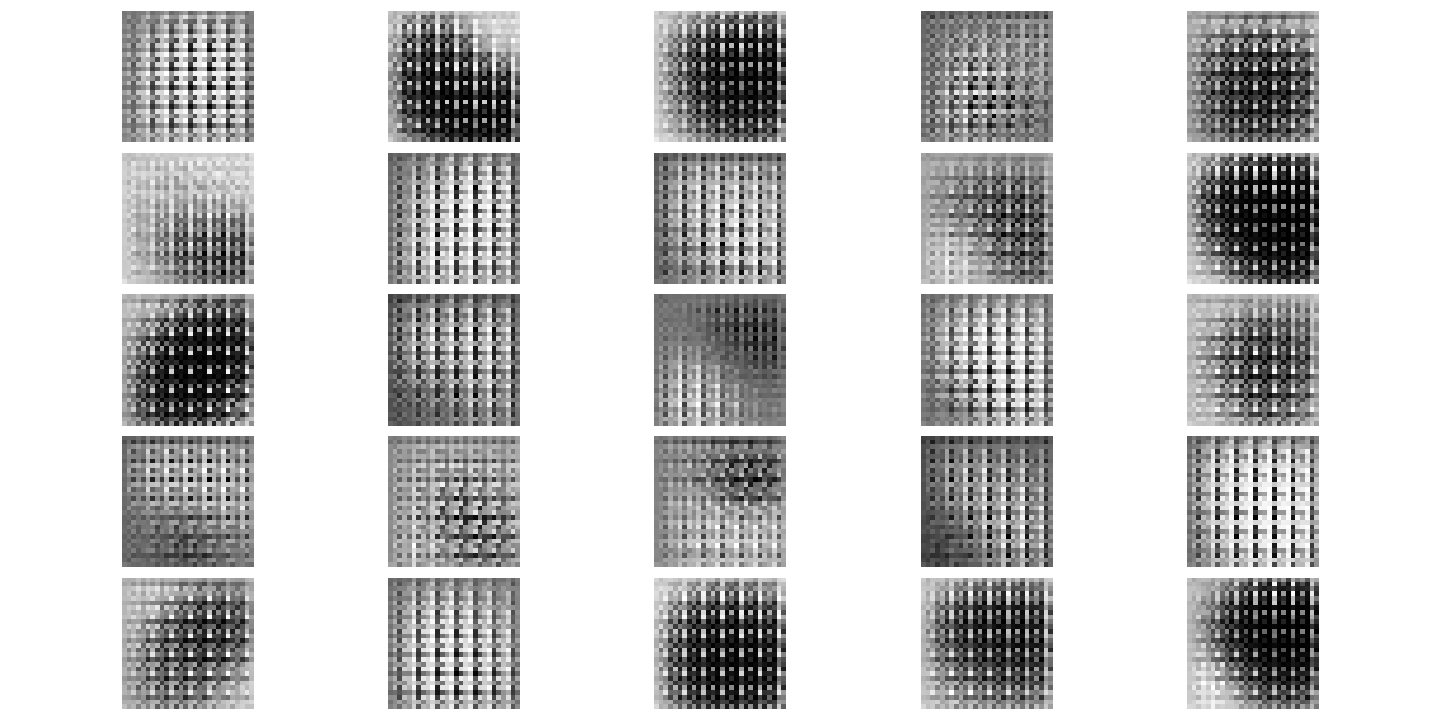

In [22]:
# PIL is a library which may open different image file formats
import PIL 

# Display a single image using the epoch number
def display_image(epoch_no):
    
    return PIL.Image.open('gan_mnist.png'.format(epoch_no))

display_image(300)

The above generated samples from the GAN were not distinguishable due to the less pixel image size of the input data. Even though the GAN is performing better than AE and VAE which is evident from the Accuracy achieved on the training dataset, we wanted to try adding a gradient tape method to the tensors and check the results. The following code is 

### Method 2 : GAN Implementation 

In [11]:
## training with gradient tape

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
# tf.function annotation causes the function 
@tf.function
def train_GAN_With_Grad(images):
  
    z = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        generated_images = GAN_generator(z, training=True)
        x_real = GAN_discriminator(images, training=True)
        x_fake = GAN_discriminator(generated_images, training=True)
        gen_loss = generator_loss(x_fake)
        disc_loss = discriminator_loss(x_real, x_fake)

    gradients_of_generator = gen_tape.gradient(gen_loss, GAN_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                GAN_discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, GAN_generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, GAN_discriminator.trainable_variables))

In [13]:
def generate_and_save_images(model, epoch, test_input):
    
    predictions = model(test_input, training=False)
  # 2 - Plot the generated images
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    # 3 - Save the generated images
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [15]:
checkpoint_dir = './training_checkpoints_4'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=GAN_generator,
                                 discriminator=GAN_discriminator)

In [17]:
def network_train(dataset, epochs):
    
    for epoch in range(epochs):
        
        start = time.time()

        for image_batch in dataset:
            train_GAN_With_Grad(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(GAN_generator,
                                 epoch + 1,
                                 seed)
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    display.clear_output(wait=True)
    
    generate_and_save_images(GAN_generator,
                           epochs,
                           seed)

In [18]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_img_GAN).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

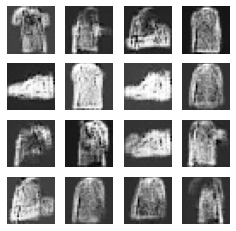

In [19]:
network_train(train_dataset, 30)

In [20]:
import glob
import imageio 

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


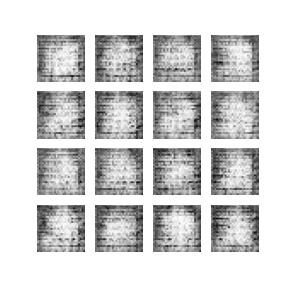

In [21]:
display.Image(open('dcgan.gif','rb').read())

We tried with various parameter to check for the right traininng parameters for our data set, We tried by taking 128 dimensions instead of 256 , got very bad picture quality image from GAN even after training for 100 epochs(3 hours). We then decided to change the decoder architecture of VAE and  generator of GAN to 256 pixels, then we were able to generate good results.

## Conclusion :
We can see that the autoencoders are able to generate similar images with minimal loss with the give architecture of a single dense layer. 
VAE takes exponentially more time to process the each epoch as compared to AE but generates more differential images as supposed to the original once when compared to the output, reducing latent and reconstruction loss at the same time with the same architecture.
The architecture of decoder of VAE and generator of GAN networks are same. Even with same parameters we can see that GAN is performing slightly better. We can render better image quality by changing the architecture.
The image quality produced by method 1 was not good , thus we implemented method 2 with gradient tape and were able to see significant improvement in the results

**Refrences:**

1) Code for GAN  - Class notes - Deep Learning - Week 9 - Dr James McDermott

2) Code for GAN using gradient method - Image Generation in 10 Minutes with Generative Adversarial Networks - (https://towardsdatascience.com/image-generation-in-10-minutes-with-generative-adversarial-networks-c2afc56bfa3b)